This notebook provides an example of how to use the `poopy` package to access historical CSO discharge monitoring data provided by water companies.

First, we import the libraries we need.

In [1]:
from poopy.companies import ThamesWater

# To help demonstrate the package
import datetime
import os
import matplotlib.pyplot as plt

First we initiate an instance of a `WaterCompany` object. We opt to use the `ThamesWater` as an example. 

In [2]:
tw_clientID = os.getenv("TW_CLIENT_ID")
tw_clientSecret = os.getenv("TW_CLIENT_SECRET")

if tw_clientID is None or tw_clientSecret is None:
    raise ValueError(
        "Thames Water API keys are missing from the environment!\n Please set them and try again."
    )

tw = ThamesWater(tw_clientID, tw_clientSecret)

Initialising Thames Water object...
Requesting current status data from Thames Water API...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeCurrentStatus?limit=1000&offset=0
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeCurrentStatus?limit=1000&offset=1000
	No more records to fetch


Initiating a `WaterCompany` object will automatically download the current status of all the monitors. What we want to do is explore historical information for past discharges. This can either be done at the level of the individual `Monitor` or at the level of the `WaterCompany`. Lets explore the former first using the "Bourton-On-The-Water" monitor.

In [3]:
monitor = tw.active_monitors["Bourton-On-The-Water"]
monitor.get_history(verbose=True)

Requesting historical data for Bourton-On-The-Water from Thames Water API...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=0&col_1=LocationName&operand_1=eq&value_1=Bourton-On-The-Water
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=1000&col_1=LocationName&operand_1=eq&value_1=Bourton-On-The-Water
	No more records to fetch
	Printing full API response...
             LocationName PermitNumber LocationGridRef       X       Y  \
0    Bourton-On-The-Water    CTCR.2036      SP17621907  417620  219070   
1    Bourton-On-The-Water    CTCR.2036      SP17621907  417620  219070   
2    Bourton-On-The-Water    CTCR.2036      SP17621907  417620  219070   
3    Bourton-On-The-Water    CTCR.2036      SP17621907  417620  219070   
4    Bourton-On-The-Water    CTCR.2036      SP17621907  417620  219070   
5    Bourton-On-The-Water    CTCR.2036      SP17621907  417620  219070   

Above, we ran the `get_history()` method that extracts the historical data for a given monitor. This information is stored in the `Monitor` object in the `history` attribute. This is a List of `Event` objects. For example, lets see what the fifth event in the history is. Recall that an `Event` object can either be a `Discharge`, `Offline` or `NoDischarge`. 

In [4]:
fifth_event = monitor.history[4]
fifth_event.print()


        
        --------------------------------------
        Event Type: Not Discharging
        Site Name: Bourton-On-The-Water
        Permit Number: CTCR.2036
        OSGB Coordinates: (417620, 219070)
        Receiving Watercourse: Groundwater
        Start Time: 2024-05-09 12:15:00
        End Time: 2024-05-22 06:15:00
        Duration: 18360.0 minutes
        


To visualise the history once it has been calculated we can use the `plot_history()` method. This will plot the history of the monitor as a 'barcode', the colour of the bar corresponds to the status of the event through time. Brown is a discharge, grey is offline and white is no discharge. Note that the barchart automatically goes back as far as the first recorded discharge or offline event for that monitor. 

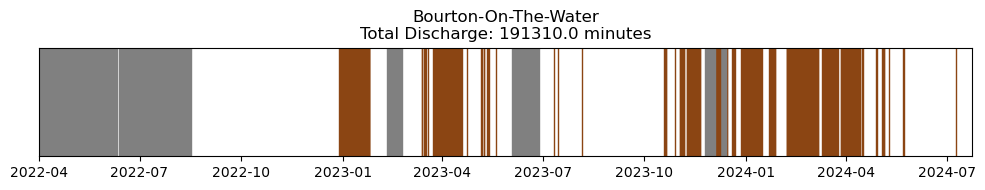

In [5]:
monitor.plot_history()

We can make it plot for a shorter period by passing a `since` parameter. For example, lets look at only the last 3 months.

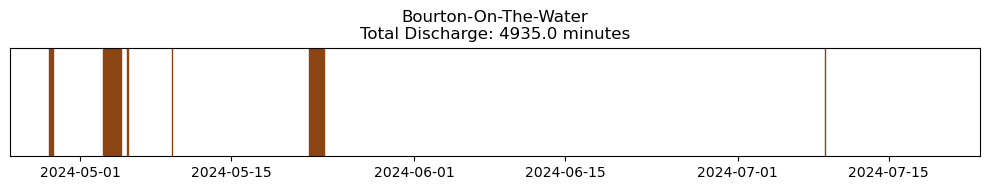

In [6]:
since_3_months = datetime.datetime.now() - datetime.timedelta(days=90) # 90 days = 3 months
monitor.plot_history(since=since_3_months)

We can print out some summary information about the total amount of discharge as follows:

In [7]:
print(f"Total discharge: {monitor.total_discharge()} minutes")
print(f"Total discharge last 12 months: {monitor.total_discharge_last_12_months()} minutes")
print(f"Total discharge last 6 months: {monitor.total_discharge_last_6_months()} minutes")
print(f"Total discharge since start of year: {monitor.total_discharge_since_start_of_year()} minutes")
print(f"Total discharge last 3 months: {monitor.total_discharge(since=since_3_months)} minutes")

Total discharge: 191310.0 minutes
Total discharge last 12 months: 125190.0 minutes
Total discharge last 6 months: 82609.39006445 minutes
Total discharge since start of year: 100320.0 minutes
Total discharge last 3 months: 4935.0 minutes


If we want to calculate the history for all monitors managed by a particular water company we can do this by calling the `set_all_histories()` method on the `WaterCompany` object. This sets the `history` attribute of all the monitors in the `WaterCompany` object.

In [8]:
tw.set_all_histories()

Requesting historical data for all monitors from Thames Water API...
	Requesting historical events since 2022-04-01 00:30:00...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=0
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=1000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=2000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=3000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=4000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=5000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=6000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/S

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Cottered contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-03-17T23:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Cottered contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-03-13T22:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Cottered contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-03-13T22:30:00. Skipping that entry...
  warnings.warn(


	Building history for Counters Creek, Lots Road...
	Building history for Craigton Road...
	Building history for Cranleigh...
	Building history for Crawley...
	Building history for Cricklade...
	Building history for Cricklewood Broadway...
	Building history for Cricklewood Lane, Cricklewood (A41 Hendon Way)...
	Building history for Crofton Road, Sunnydale...
	Building history for Crondall...
	Building history for Crooked Billet...
	Building history for Cropredy...
	Building history for Crossness...
	Building history for Cuddington...
	Building history for Culham...
	Building history for Culworth...
	Building history for Dagnall...
	Building history for Daintry Close...
	Building history for Dallow Road Jnc Lyndhurst Road...
	Building history for Darkes Lane, Potters Bar...
	Building history for Dartford Creek Storm...
	Building history for Dartnell Park, Byfleet...
	Building history for Deadmans Bridge...
	Building history for Dean Oak Lane...
	Building history for Deephams...
	Building

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Dartford Creek Storm contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-10-15T23:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Dartford Creek Storm contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-12-06T03:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Dartford Creek Storm contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-12-06T03:00:00. Skipping that entry...
  warnings.warn(


	Building history for Deptford Storm Relief...
	Building history for Didcot...
	Building history for District Road...
	Building history for Dorchester...
	Building history for Dorking...
	Building history for Dorking Road...
	Building history for Dorton...
	Building history for Draycot Foliat...
	Building history for Drayton (Oxon)...
	Building history for Dunstable Road - Beech Road...
	Building history for Dunstable Road - Beech Road CSO 2...
	Building history for Dunstable Road - Francis Street...
	Building history for Duntshill Road...
	Building history for Earl...
	Building history for Earlswood (Reigate)...
	Building history for Earlswood Common, S Of Pendleton Road...
	Building history for East Garston...
	Building history for East Grafton...
	Building history for East Lane CSO 1...
	Building history for East Lane CSO 2...
	Building history for East Shefford...
	Building history for Eastcote Avenue...
	Building history for Easthampstead Park...
	Building history for Edgware Road

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Faringdon House CSO contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-06-14T15:06:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Faringdon House CSO contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-06-10T13:14:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Faringdon House CSO contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-06-10T13:14:00. Skipping that entry...
  warnings.warn(


	Building history for Farnham...
	Building history for Fergusson Road, Banbury...
	Building history for Field End Rd Storm (Harrow)...
	Building history for Field End Road (East)...
	Building history for Finstock...
	Building history for Fleet...
	Building history for Fleet Main Line Sewer...
	Building history for Folkestone Rd Tanks, East Ham...
	Building history for Forest Hill...
	Building history for Francis Road Spill...
	Building history for Friday Street, Henley...
	Building history for Frogmore Storm...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Frogmore Storm contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-10-02T08:46:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Frogmore Storm contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-09-08T10:48:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Frogmore Storm contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-09-08T10:48:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packa

	Building history for Fulmer Drive CSO (Howards Wood Drive)...
	Building history for Fyfield (Wilts)...
	Building history for Gap Road (Cemetery)...
	Building history for Garden Way...
	Building history for Gascoigne Rd Storm Tanks, Beckton...
	Building history for George Street - King Street...
	Building history for George Street - Wellington Street...
	Building history for Gerrards Cross...
	Building history for Godalming...
	Building history for Gordon Road...
	Building history for Gordon Road (u205)...
	Building history for Goring...
	Building history for Goswell Street...
	Building history for Granville Road...
	Building history for Great Bedwyn...
	Building history for Greatworth...
	Building history for Greenwich...
	Building history for Grendon Underwood...
	Building history for Guildford...
	Building history for Gun Wharf (Wapping Dock)...
	Building history for Haddenham...
	Building history for Hadham Mill...
	Building history for Hambleden...
	Building history for Hammersmit

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Knights Lane contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-04-06T10:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Knights Lane contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-12-21T05:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Knights Lane contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-12-21T05:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/po

	Building history for Leopold Road, Church Path...
	Building history for Leverson Street...
	Building history for Lightwater...
	Building history for Lincoln Road CSO...
	Building history for Lindsay Drive, Falcon Way...
	Building history for Little Compton...
	Building history for Little Hallingbury...
	Building history for Little Marlow...
	Building history for Little Milton...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Little Milton contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-01-12T15:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Little Milton contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-12-19T11:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Little Milton contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-12-19T11:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages

	Building history for Littlemead Ind Estate, Cranleigh...
	Building history for Littlemore Low Level...
	Building history for London Bridge...
	Building history for London Road Near Hatherop Lane...
	Building history for London Road, Marlborough...
	Building history for Long Crendon...
	Building history for Long Reach...
	Building history for Longbridge Road...
	Building history for Longley Road (1), Tooting High Street...
	Building history for Longstone Ave, Drayton Road...
	Building history for Low Hall Farm Storm Tanks, Walthamstow...
	Building history for Low Level 1 N, Grosvenor Ditch, Millb...
	Building history for Lower Cherwell St, Banbury...
	Building history for Ludgershall...
	Building history for Luton...
	Building history for Lyon Park Avenue...
	Building history for Lytton Road SSO...
	Building history for Maidenhead...
	Building history for Main Road, Sidcup...
	Building history for Manor Drive Stormwater Tanks...
	Building history for Manor Farm...
	Building history for

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Ne Storm Relief Shadwell, King Edward Mem Park contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-12-04T12:38:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Ne Storm Relief Shadwell, King Edward Mem Park contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-12-01T09:32:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Ne Storm Relief Shadwell, King Edward Mem Park contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-12-01T09:32:00. Ski

	Building history for Newbury...
	Building history for Newmans Lane...
	Building history for Nightingale Lane...
	Building history for Norfolk Street...
	Building history for North End Road CSO...
	Building history for North Weald...
	Building history for North West Storm Relief...
	Building history for Northleach...
	Building history for Northumberland Street...
	Building history for Nutter Lane / Preston Drive, Wanstead...
	Building history for Oak Hill Park CSO...
	Building history for Oakentrough...
	Building history for Oakley Road...
	Building history for Ockham Road South Foul Sewer Overflow...
	Building history for Ockley Road...
	Building history for Old Palace Lane ...
	Building history for Opposite St Stephens Hall...
	Building history for Outside 115 Wentworth Road...
	Building history for Outside 135 Leeside Crescent (Formerly Brookside Road, Golders Green)...
	Building history for Oxford...
	Building history for Pangbourne...
	Building history for Park Street - Bailey Str

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Stanton Fitzwarren STW contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-10-15T20:56:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Stanton Fitzwarren STW contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-10-13T16:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Stanton Fitzwarren STW contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-10-13T16:00:00. Skipping that entry...
  warnings.warn(


	Building history for Stewkley...
	Building history for Stoke Road, Cobham...
	Building history for Stone...
	Building history for Stonebridge Brook...
	Building history for Stonebridge SSO, Brockham...
	Building history for Streatham & Balham Storm Relief...
	Building history for Streatham Storm Relief...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Stonebridge SSO, Brockham contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2022-10-27T10:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Stonebridge SSO, Brockham contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-10-23T10:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:285: UserWarning: ! WARNING ! Alert stream for monitor Stonebridge SSO, Brockham contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-10-23T10:30:00. Skipping that entry...
  warnings.warn(


	Building history for Streatham Vale Storm Relief...
	Building history for Sudbury Heights Ave, Allendale Road...
	Building history for Sunnyside Road...
	Building history for SW Storm Relief Sewer, London...
	Building history for Swains Road...
	Building history for Swindon (Rodbourne)...
	Building history for Tackley...
	Building history for Takeley...
	Building history for Takeley - Garnetts...
	Building history for Taylors Crescent, Cranleigh...
	Building history for Temple Place Essex Street...
	Building history for Tetsworth...
	Building history for Thame...
	Building history for The Broadway (Ray Park 2)...
	Building history for The Willows, North Hinksey Lane...
	Building history for Therfield...
	Building history for Theydon Bois...
	Building history for Thornwood...
	Building history for Thrale Road...
	Building history for Tideway CSO...
	Building history for Tokyngton Avenue...
	Building history for Tonstall Road...
	Building history for Tree Tops, Norbury...
	Building hist

Then, the monitor's history object can be accessed as before. For example, lets get the history for the "Marlborough" monitor.

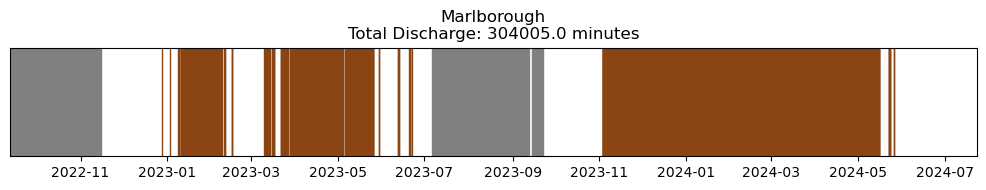

In [9]:
monitor = tw.active_monitors["Marlborough"]
monitor.plot_history()

We can query what event was occurring at a particular time as follows: 

In [10]:
time = datetime.datetime(2024, 1, 1)
event = monitor.event_at(time)
event.print()


        
        --------------------------------------
        Event Type: Discharging
        Site Name: Marlborough
        Permit Number: TEMP.2763
        OSGB Coordinates: (420120, 169200)
        Receiving Watercourse: River Kennet
        Start Time: 2023-12-31 15:45:00
        End Time: 2024-01-01 00:45:00
        Duration: 540.0 minutes
        


Alternatively, we can get all of the discharge events in the form of a `pandas` dataframe using the `get_history_df()` method. This returns a dataframe that contains all the discharge events for all the monitors managed by the water company, sorted from newest to oldest start times. This dataframe can then be analysed using standard pandas methods. The head of this dataframe is shown below:

In [11]:
df = tw.history_to_discharge_df()
print(df.head())

Building output data-table
	Processing (Northern) Low Level No 1 Brook Green
	Processing 15 Coldharbour Lane, Bushey
	Processing Abbess Roding
	Processing Abbey Mills
	Processing Abbeydale Road
	Processing Abingdon
	Processing Acton & Storm Works
	Processing Aldermaston
	Processing Aldershot Town
	Processing Alicia Avenue CSO
	Processing Allendale Road
	Processing Amersham Balancing Tanks/Amersham Vale STK
	Processing Ampney St Peter
	Processing Amyand Park Road, Twickenham
	Processing Andoversford
	Processing Appleton
	Processing Arborfield
	Processing Arford
	Processing Ascot
	Processing Ash Ridge (Wokingham)
	Processing Ash Vale
	Processing Aston Le Walls
	Processing Auckland Road Storm Tanks
	Processing Avon Dassett
	Processing Avondale Rd
	Processing Aylesbury
	Processing Bakers Farm, High Wych
	Processing Bampton
	Processing Banbury
	Processing Banbury Rd Middleton Cheney
	Processing Bancroft Rugby Ground, Buckhurst Hill
	Processing Barbers Lane
	Processing Barkway
	Processing Ba

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/poopy.py:505: UserWarning: !WARNING! Event is ongoing and has no end time. Returning None.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/poopy.py:1084: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, event._to_row()], ignore_index=True)


	Processing Box Hill
	Processing Boyne Avenue, Hendon
	Processing Bracknell
	Processing Bramley
	Processing Brent Cross Flyover
	Processing Brent Valley Golf Course, LB Ealing
	Processing Brentfield Gardens
	Processing Brickendon
	Processing Bridle Close, Ewell
	Processing Brixton Storm Relief Sewer
	Processing Broadwell
	Processing Brockham Bridge
	Processing Brook Way, Chigwell
	Processing Broome (Attenuation Tank)
	Processing Bucklebury (Briff Lane)
	Processing Bucknell
	Processing Buntingford
	Processing Burford
	Processing Burghfield
	Processing Burstow
	Processing Bushey Court, Raynes Park
	Processing Bute Street CSO
	Processing Byfield
	Processing Caddington
	Processing Cage End, Essex
	Processing Camberley
	Processing Canfield End, Little Canfield
	Processing Canfold Wood
	Processing Canterbury Road, Thornton Heath
	Processing Capel
	Processing Carlton Cres Jnc Blenheim Cres
	Processing Carterton
	Processing Cascade Road Storm Tanks, Buckhurst
	Processing Cassington
	Processing

This can then be saved to file using the standard Pandas methods. For example, to save it as a CSV file that can be analysed using other tools (e.g, Excel) we can do the following:

In [12]:
filename = tw.name + tw.history_timestamp.strftime("%y%m%d%H%M%S") + ".csv"
print(f"Saving history to {filename}")
df.to_csv(filename, header=True, index=False)

Saving history to ThamesWater240723114036.csv


We can do a similar thing for the offline events using the `history_to_offline_df()` method. This returns a dataframe that contains all the offline events for all the monitors managed by the water company, sorted from newest to oldest start times.

In [13]:
offline_df = tw.history_to_offline_df()
print(offline_df.head())

Building output data-table
	Processing (Northern) Low Level No 1 Brook Green
	Processing 15 Coldharbour Lane, Bushey
	Processing Abbess Roding
	Processing Abbey Mills
	Processing Abbeydale Road
	Processing Abingdon
	Processing Acton & Storm Works
	Processing Aldermaston
	Processing Aldershot Town
	Processing Alicia Avenue CSO
	Processing Allendale Road
	Processing Amersham Balancing Tanks/Amersham Vale STK
	Processing Ampney St Peter
	Processing Amyand Park Road, Twickenham
	Processing Andoversford
	Processing Appleton
	Processing Arborfield
	Processing Arford
	Processing Ascot
	Processing Ash Ridge (Wokingham)
	Processing Ash Vale
	Processing Aston Le Walls
	Processing Auckland Road Storm Tanks
	Processing Avon Dassett
	Processing Avondale Rd
	Processing Aylesbury
	Processing Bakers Farm, High Wych
	Processing Bampton
	Processing Banbury
	Processing Banbury Rd Middleton Cheney
	Processing Bancroft Rugby Ground, Buckhurst Hill
	Processing Barbers Lane
	Processing Barkway
	Processing Ba

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/poopy.py:505: UserWarning: !WARNING! Event is ongoing and has no end time. Returning None.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/poopy.py:1113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, event._to_row()], ignore_index=True)


	Processing Lindsay Drive, Falcon Way
	Processing Little Compton
	Processing Little Hallingbury
	Processing Little Marlow
	Processing Little Milton
	Processing Littlemead Ind Estate, Cranleigh
	Processing Littlemore Low Level
	Processing London Bridge
	Processing London Road Near Hatherop Lane
	Processing London Road, Marlborough
	Processing Long Crendon
	Processing Long Reach
	Processing Longbridge Road
	Processing Longley Road (1), Tooting High Street
	Processing Longstone Ave, Drayton Road
	Processing Low Hall Farm Storm Tanks, Walthamstow
	Processing Low Level 1 N, Grosvenor Ditch, Millb
	Processing Lower Cherwell St, Banbury
	Processing Ludgershall
	Processing Luton
	Processing Lyon Park Avenue
	Processing Lytton Road SSO
	Processing Maidenhead
	Processing Main Road, Sidcup
	Processing Manor Drive Stormwater Tanks
	Processing Manor Farm
	Processing Maple Lodge
	Processing Mapleton Road
	Processing Markenfield Road, Guildford
	Processing Markyate
	Processing Marlborough
	Processing

We may want to work out the particular downstream impact at a given point in time. For example, if we wanted to know how many upstream discharges were ocurring at a particular point in the drainage network at a specific point in time. This is possible as follows: 

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/poopy.py:351: UserWarning: 
! WARNING ! No event found at 2024-07-16 00:00:00 for Bampton. 
Probably the monitor was not active at that time OR has no recorded events. 
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/poopy.py:351: UserWarning: 
! WARNING ! No event found at 2024-07-16 00:00:00 for Barbers Lane. 
Probably the monitor was not active at that time OR has no recorded events. 
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/poopy.py:351: UserWarning: 
! WARNING ! No event found at 2024-07-16 00:00:00 for Birchanger - Duck End. 
Probably the monitor was not active at that time OR has no recorded events. 
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/poopy.py:351: UserWarning: 
! WARNING ! No event found at 2024-07-16 00:00:00 for Bridle Close, Ewell. 
Probably the monitor was not active at that

(Text(0.5, 0, 'Easting'), Text(0, 0.5, 'Northing'))

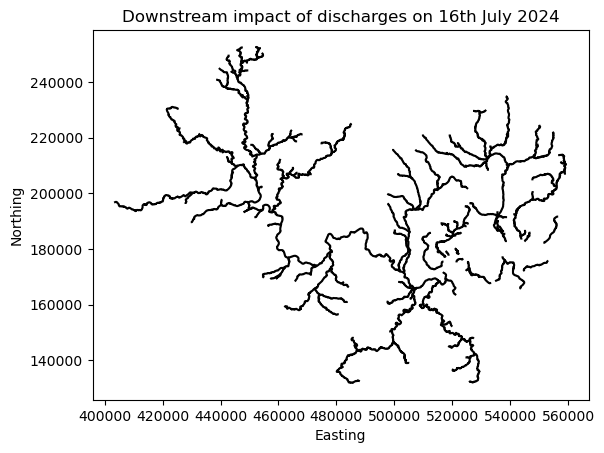

In [14]:
time = datetime.datetime(2024, 7, 16) # 16th July 2024
downstream = tw.get_historical_downstream_impact_at(time=time, include_recent_discharges=True) # Calculate downstream impact on 16th July, including recent discharges (within 48 hours)

# `downstream` is a 2D numpy array with the # number of discharges upstream of each cell on the DEM grid
# We can cast it to a geojson for easier visualisation

geojson = tw._accumulator.get_channel_segments(downstream, threshold=0.9)
segs = tw._accumulator.get_channel_segments(downstream, threshold=0.9)
for line in segs["coordinates"]:
    x = [c[0] for c in line]
    y = [c[1] for c in line]
    plt.plot(x, y, color="k")
plt.title("Downstream impact of discharges on 16th July 2024")
plt.xlabel("Easting"), plt.ylabel("Northing")

In fact, we can go further and calculate more detailed information about the downstream impact of CSOs at any point in the past. For example, we can calculate the total number of upstream discharges, and the number of upstream discharges per unit area, as well as the list of names of upstream discharges. This is done as follows: 

In [15]:
info_geojson = tw.get_historical_downstream_info_geojson_at(time=time, include_recent_discharges=True)

We can then visualise this: 

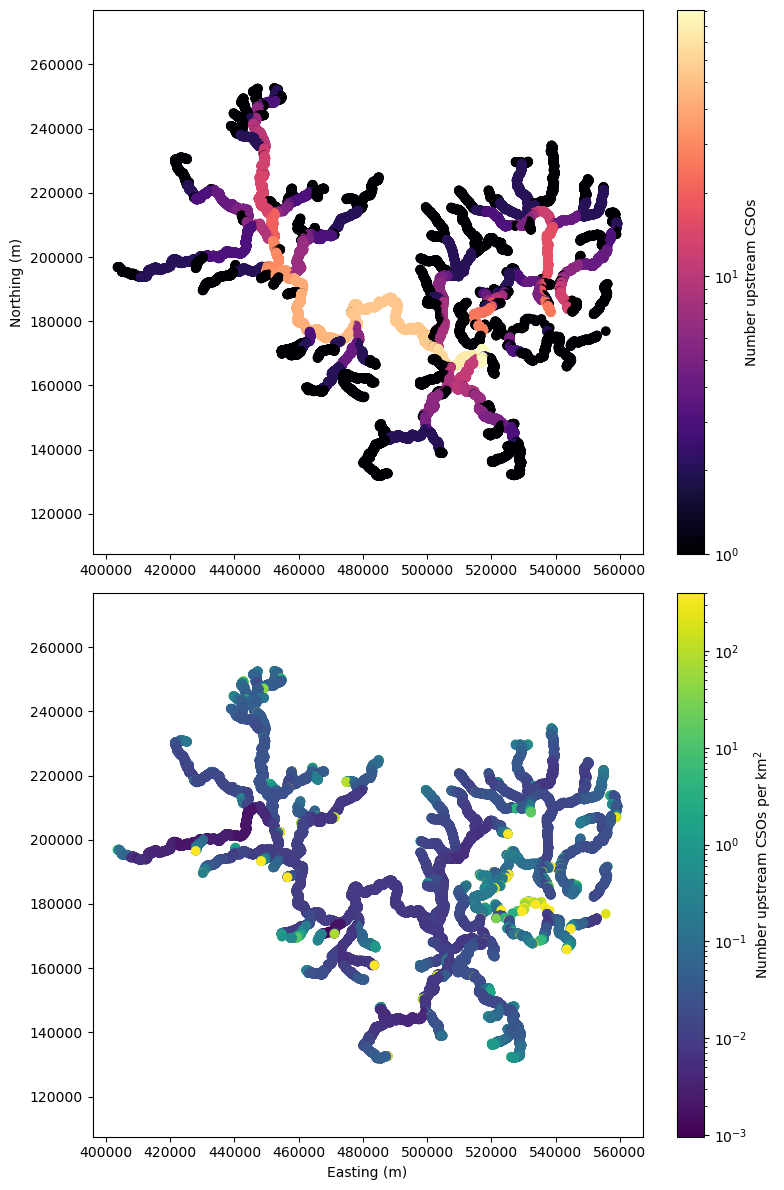

In [16]:
from matplotlib.colors import LogNorm

x, y, num_upst, num_upst_per_km2 = [], [], [], []
for feature in info_geojson.features:
    x.append(feature.geometry.coordinates[0])
    y.append(feature.geometry.coordinates[1])
    num_upst.append(feature.properties["number_upstream_CSOs"])
    num_upst_per_km2.append(feature.properties["number_CSOs_per_km2"])

plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.scatter(x, y, c=num_upst, norm=LogNorm(), cmap="magma")
plt.ylabel("Northing (m)")
plt.axis("equal")
cb = plt.colorbar()
cb.set_label("Number upstream CSOs")
plt.subplot(2, 1, 2)
plt.scatter(x, y, c=num_upst_per_km2, norm=LogNorm(), cmap="viridis")
plt.axis("equal")
cb = plt.colorbar()
cb.set_label("Number upstream CSOs per km$^2$")
plt.xlabel("Easting (m)")
plt.tight_layout()
plt.show()

Lets say we want to look at how CSO overflows have changed over time. Or perhaps how many monitors are online at any one time across a water companies patch. We can do this using the `get_monitor_timeseries()` method of a `WaterCompany`. This generates time series of the number of active CSOs, recently active CSOs and online monitors at 15 minute intervals (the approximate frequency of the data). Lets generate this data from the start of 2022.

In [17]:
since = datetime.datetime(2022, 1, 1)
monitor_series = tw.get_monitor_timeseries(since=since)

Processing (Northern) Low Level No 1 Brook Green
Processing 15 Coldharbour Lane, Bushey
Processing Abbess Roding
Processing Abbey Mills
Processing Abbeydale Road
Processing Abingdon
Processing Acton & Storm Works
Processing Aldermaston
Processing Aldershot Town
Processing Alicia Avenue CSO
Processing Allendale Road
Processing Amersham Balancing Tanks/Amersham Vale STK
Processing Ampney St Peter
Processing Amyand Park Road, Twickenham
Processing Andoversford
Processing Appleton
Processing Arborfield
Processing Arford
Processing Ascot
Processing Ash Ridge (Wokingham)
Processing Ash Vale
Processing Aston Le Walls
Processing Auckland Road Storm Tanks
Processing Avon Dassett
Processing Avondale Rd
Processing Aylesbury
Processing Bakers Farm, High Wych
Processing Bampton
Processing Banbury
Processing Banbury Rd Middleton Cheney
Processing Bancroft Rugby Ground, Buckhurst Hill
Processing Barbers Lane
Monitor Barbers Lane has no recorded events
Processing Barkway
Processing Basingstoke
Process

Now lets plot the results.

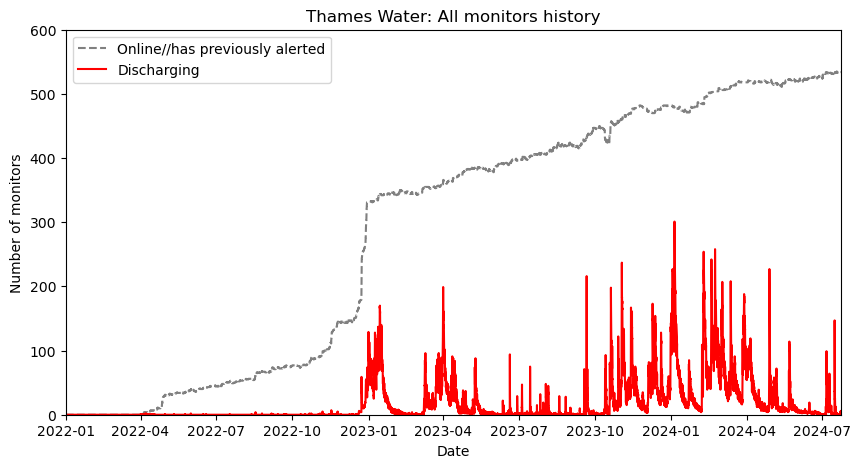

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_online"],
    c="grey",
    label="Online//has previously alerted",
    linestyle="dashed",
)
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_discharging"],
    c="red",
    label="Discharging",
)
plt.ylabel("Number of monitors")
plt.xlabel("Date")
# Set the xlimits to be the min and max of the datetime column
plt.xlim(monitor_series["datetime"].min(), monitor_series["datetime"].max())
plt.ylim(0, 600)
plt.title("Thames Water: All monitors history")
plt.legend()
plt.show()

Note that for "online" we conservatively assume that every monitor was _offline_ until we receive any positive event from it. This means that if a monitor is installed but recording    'NotDischarging' for a month until its first discharge event, it will be counted as offline for that month. Lacking any other information, this is the most conservative assumption we can make.  The first few monitors were attached to the API in April 2022, so the number of monitors "online" since then rises. But, in December '22/January '23 many more were hooked up and so the number of monitors "online" spikes. Since then, the coverage has got gradually better but the number of active monitors has remained fairly constant. It is therefore inappropriate to use this dataset to compare discharge histories between 2022 and 2023, as the number of active monitors has changed so much. You should use the annual returns for that instead. As expected there are more CSOs active during the winter months. To get a more averaged (less 'spiky') view of the data we can look at those which have been active in the last 48 hours (shown below) but the overall picture is the same.

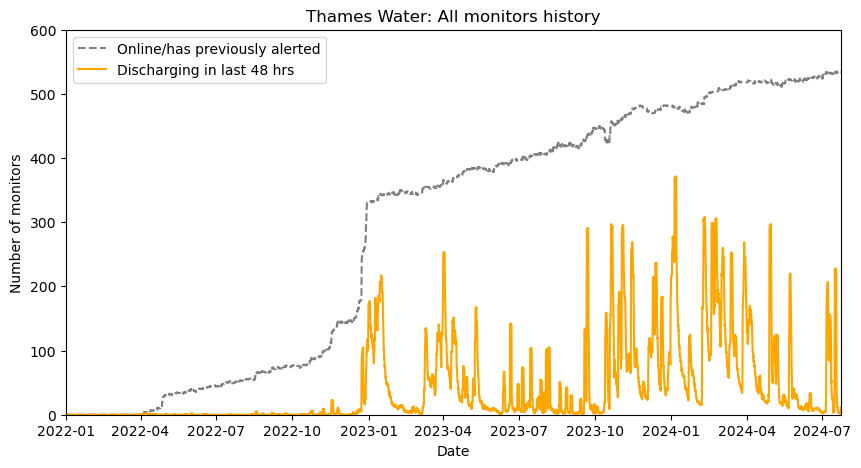

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_online"],
    c="grey",
    label="Online/has previously alerted",
    linestyle="dashed",
)
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_recently_discharging"],
    c="orange",
    label="Discharging in last 48 hrs",
)
plt.ylabel("Number of monitors")
plt.xlabel("Date")
# Set the xlimits to be the min and max of the datetime column
plt.xlim(monitor_series["datetime"].min(), monitor_series["datetime"].max())
plt.ylim(0, 600)
plt.title("Thames Water: All monitors history")
plt.legend()
plt.show()

Finally we can see how easy it is to generate some simple statistics about the data. For example:

In [20]:
number_online_now = monitor_series["number_online"].iloc[-1]
print(f"Number of monitors 'online' now: {number_online_now}")
number_discharging_now = monitor_series["number_discharging"].iloc[-1]
print(f"Number of monitors discharging now: {number_discharging_now}")
print(f"Proportion of monitors discharging now: {number_discharging_now / number_online_now * 100:.2f}%")
number_recently_discharging_now = monitor_series["number_recently_discharging"].iloc[-1]
print(f"Number of monitors discharging in last 48 hrs: {number_recently_discharging_now}")
print(f"Proportion of monitors discharging in last 48 hrs: {number_recently_discharging_now / number_online_now * 100:.2f}%")

Number of monitors 'online' now: 534
Number of monitors discharging now: 3
Proportion of monitors discharging now: 0.56%
Number of monitors discharging in last 48 hrs: 11
Proportion of monitors discharging in last 48 hrs: 2.06%
